### Libraries and Functions

In [ ]:
library(rtracklayer)
library(kableExtra)    
library(magrittr)
library(tidyr)
library(gGnome)
library(gUtils)
library(parallel)
library(GenomeInfoDb)
library(tidyverse)

events2 = function(gg, verbose = TRUE, mark = FALSE, QRP = FALSE)
{
  #gg = gg %>% simple(mark = TRUE)
  #if (verbose)
  #  message('Finished simple')
  tryCatch({
    gg = gg %>% amp(mark = TRUE)
    if (verbose)
      message('Finished amp (tyfonas, dm, cpxdm, bfb)')
  }, error = function(e) {}, finally = {})

  tryCatch({
    gg = gg %>% chromothripsis(mark = TRUE)
    if (verbose)
      message('Finished chromothripsis')
  }, error = function(e) {}, finally = {})

  tryCatch({
    gg = gg %>% chromoplexy(mark = TRUE)
    if (verbose)
      message('Finished chromoplexy')
  }, error = function(e) {}, finally = {})

  tryCatch({
    gg = gg %>% tic(mark = TRUE)
    if (verbose)
      message('Finished tic')
  }, error = function(e) {}, finally = {})

  if (QRP){
    gg = gg %>% qrp(mark = TRUE)
    if (verbose)
      message('Finished qrp')
  }
  
  ev = rbind(
    #gg$meta$simple,
    gg$meta$chromothripsis,
    gg$meta$chromoplexy,
    gg$meta$rigma,
    gg$meta$pyrgo,
    gg$meta$tic,
    gg$meta$amp, fill = TRUE)[, ev.id := seq_len(.N)]
  if (QRP){
    ev = rbind(
      ev,
      gg$meta$qrp,
      ## gg$meta$qrpmix, #' ARRRGGGHHHH keh2019 Wednesday, Jan 26, 2022, Week 04, 07:53:16 PM
      gg$meta$qrppos,
      gg$meta$qrpmin,
      gg$meta$qrpmix, fill = TRUE)[, ev.id := seq_len(.N)]
  }
  
  gg$set(events = ev)
  return(gg)
}



### Main

In [ ]:

main_dir = '/Users/lye1/data/projects_akdemirlab/catalyst_main/'
jab_v3_dir = "/Users/lye1/data/projects_akdemirlab/catalyst_wgs/results/jba_v3_all"
script_dir = "/Users/lye1/data/projects_akdemirlab/catalyst_wgs/scripts"

figures_dir = "/Users/lye1/data/projects_akdemirlab/catalyst_wgs/results/jba_figures_v3"
summary_dir = "/Users/lye1/data/projects_akdemirlab/catalyst_wgs/results/jba_summary_v3"
options(stringsAsFactors = FALSE)
setwd("/Users/lye1/data/projects_akdemirlab/catalyst_wgs/results");


##====================================================
## Read metadata and plot whole genome and every each chromosome
##

#data_meta = read_csv(file.path(script_dir, "meta_jabba.csv"))
data_meta = read_csv(file.path(main_dir, 'meta/meta_catalyst-main_v1.0_12_06.csv'))
##====================================================
## Complex SV types
##
sv_types = tibble()
complex_sv_summary = tibble()

for(row in 1:nrow(data_meta))
#for(row in 1:4)
{
    normal = data_meta[[row, "blood_wgs_seq_id"]]
    tumor = data_meta[[row, "wgs_seq_id"]]
    #if ((tumor!="239238-WG01") && (tumor!="239223-WG01")) # 
    #{
    #  next
    #}
    print(tumor)
    
    mrn = data_meta[[row, "MRN"]]
    
    black_list = data_meta[[row, "WGS-Blacklisted"]]
    if(black_list == 'N')
    {
      next
    }

    jab_v3_file = file.path(jab_v3_dir, tumor, "jabba.simple.rds")
    jab_v3 = gG(jabba = jab_v3_file)
    jab_v3_sub = jab_v3$nodes[seqnames=="1" |seqnames=="2" |seqnames=="3" |seqnames=="4" |seqnames=="5" |seqnames=="6" |seqnames=="7" |seqnames=="8" |seqnames=="9" |seqnames=="10" |
                            seqnames=="11"|seqnames=="12"|seqnames=="13"|seqnames=="14"|seqnames=="15"|seqnames=="16"|seqnames=="17"|seqnames=="18"|seqnames=="19"|seqnames=="20"|
                            seqnames=="21"|seqnames=="22"|seqnames=="X"|seqnames=="Y"]$subgraph

    jab_v3_sub = events2(jab_v3_sub, verbose = TRUE)

    edge_type=jab_v3_sub$edges[type!=REF]$class
    if(length(edge_type)>0)
    {
      dm = jab_v3_sub$edges[type!=REF]$dt$dm
      tic = jab_v3_sub$edges[type!=REF]$dt$tic
      bfb = jab_v3_sub$edges[type!=REF]$dt$bfb
      chromothripsis = jab_v3_sub$edges[type!=REF]$dt$chromothripsis
      chromoplexy = jab_v3_sub$edges[type!=REF]$dt$chromoplexy
      #print(jab_v3_sub$edges[type!=REF]$dt)
      #sv_tmp = jab_v3_sub$edges[type!=REF]$dt %>% as_tibble() %>% select( ALT, dm, tic, bfb, chromothripsis, chromoplexy)
      CHROM	= as.character(jab_v3_sub$edges[type!=REF]$dt$CHROM)
      POS	= jab_v3_sub$edges[type!=REF]$dt$POS
      ALT = jab_v3_sub$edges[type!=REF]$dt$ALT
      if(is.null(dm)){dm=NA}
      if(is.null(tic)){tic=NA}
      if(is.null(bfb)){bfb=NA}
      if(is.null(chromothripsis)){chromothripsis=NA}
      if(is.null(chromoplexy)){chromoplexy=NA}
      sv_tmp = data.frame(name=tumor, type=edge_type, CHROM=CHROM, POS=POS, ALT=unlist(ALT), dm=dm, tic=tic, bfb=bfb,chromothripsis=chromothripsis, chromoplexy=chromoplexy)
      #print(sv_tmp)
      sv_types = rbind(sv_types, sv_tmp)
    }

    tmp = data.frame()
    
    if(nrow(jab_v3_sub$meta$event) ==0)
    {
      print('empty, next')
      next
    }
    tmp = jab_v3_sub$meta$event[, table(type)] %>% data.frame()
    tmp$name = tumor

  if(nrow(tmp) ==0)
  {
    print('empty, next')
    next
  }
  complex_sv_summary = rbind(complex_sv_summary, tmp)
}



In [4]:
complex_sv_summary

type,Freq,name
<fct>,<int>,<chr>
bfb,1,239238-WG01
chromoplexy,1,239238-WG01
chromothripsis,1,239238-WG01
dm,1,239238-WG01


In [45]:
complex_sv_summary_with_meta = complex_sv_summary %>% left_join(data_meta, by=join_by(name == wgs_seq_id))
complex_sv_summary_with_meta = complex_sv_summary_with_meta %>% dplyr::select(MRN, patient_id, sample_id, IDH, name, type, Freq) %>% rename(wgs_seq_id = name)

In [46]:
comut_complex = complex_sv_summary_with_meta %>% dplyr::select(wgs_seq_id, type)
comut_complex$category = 'complex_sv'
comut_complex = comut_complex %>% dplyr::rename(sample=wgs_seq_id, value=type)
write_csv(comut_complex, "/Users/lye1/data/projects_akdemirlab/catalyst_main/results/figure_comut_v2/comut_complex_sv.csv")

`summarise()` has grouped output by 'type', 'Freq'. You can override using the
`.groups` argument.


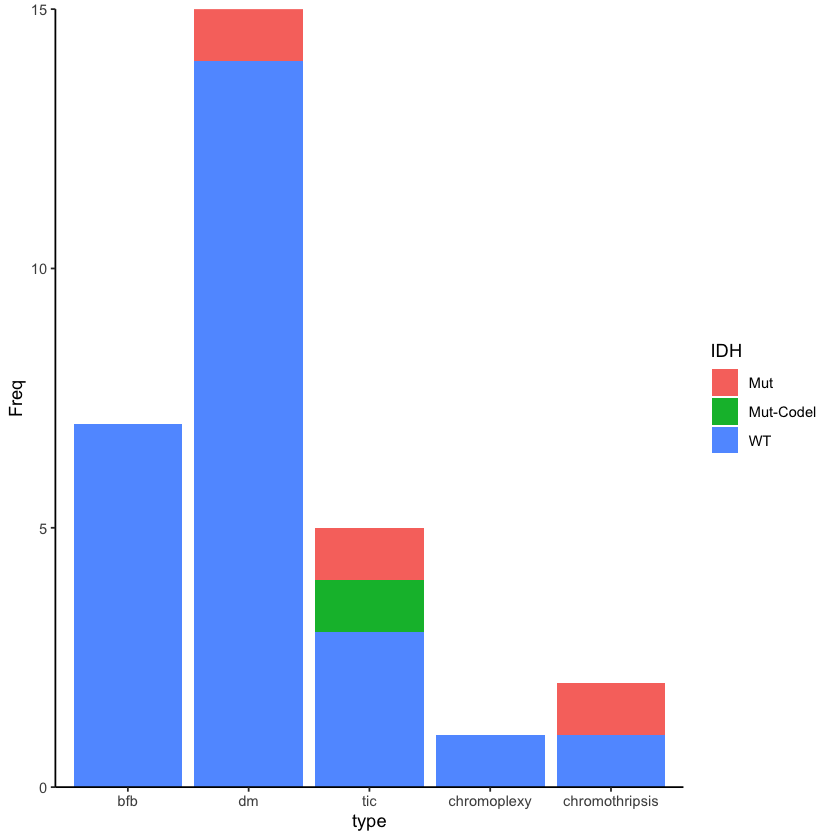

In [33]:
complex_sv_summary_x = complex_sv_summary_with_meta %>%
  group_by(type, Freq, IDH) %>%
  summarise(Freq = sum(Freq))

ggplot(complex_sv_summary_x, aes(x=type, y=Freq, fill=IDH)) +
  geom_bar(stat="identity") + scale_y_continuous(expand = c(0, 0)) + 
  theme_classic()
#ggplot(complex_sv_summary_x, aes(x=type, y=Freq, fill=Type)) +
#  geom_bar(stat="identity") + scale_y_continuous(expand = c(0, 0)) + 
#  theme_classic() +
#  theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1)) + facet_wrap(~IDH)

`summarise()` has grouped output by 'type', 'Freq'. You can override using the
`.groups` argument.


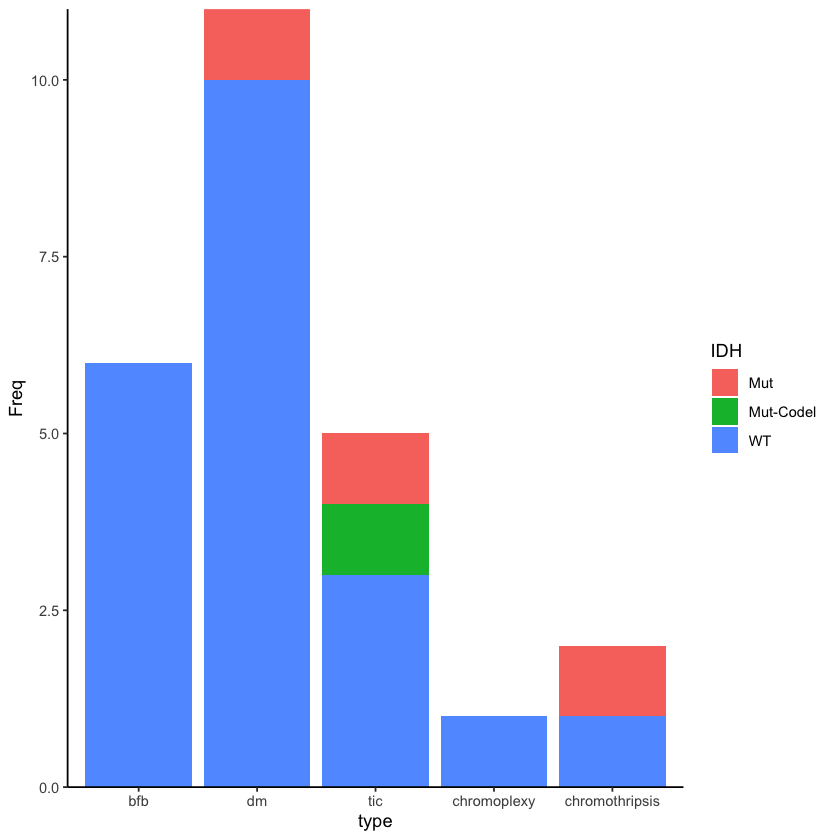

In [35]:
complex_sv_summary_x = complex_sv_summary_with_meta %>%
  group_by(type, Freq, IDH) %>%
  summarise(Freq = n())

ggplot(complex_sv_summary_x, aes(x=type, y=Freq, fill=IDH)) +
  geom_bar(stat="identity") + scale_y_continuous(expand = c(0, 0)) + 
  theme_classic()
#ggplot(complex_sv_summary_x, aes(x=type, y=Freq, fill=Type)) +
#  geom_bar(stat="identity") + scale_y_continuous(expand = c(0, 0)) + 
#  theme_classic() +
#  theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1)) + facet_wrap(~IDH)